### WBS Coding School
___
### --PROJECT--
# Supervised Machine Learning
### :: Regression: Housing prices

- *01: Data Preparation and Exploration*
- *02: Baseline Model*
- **03: Feature Selection**
- *04: Model Training and Selection*

___

# Feature Selection
___

In this script, we will explore collinearity in our data and try out the two automated feature selection methods: 
- **Sequential Feature Selection** and 
- **Recursive Feature Elimination**.

For a guide on feature selection, check out the [sklearn documentation](https://scikit-learn.org/stable/modules/feature_selection.html).

## Table of contents:
- [1 Explore Collinearity](#exploration)
- [2 Feature Selection](#feature_selection)
    - [2.1 Sequential Feature Selection](#sfs)
    - [2.2 Recursive Feature Elimination](#RFE)

#### Import Libraries, Data & Preprocessing Pipeline

In [15]:
import pandas as pd
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [16]:
# Import the cleaned data
housing_data = pd.read_csv("data/train_clean.csv")

# Import the preprocessing pipeline
preprocessing_pipe = joblib.load('pipelines/preprocessing_pipe.joblib')

#### Splitting

In [17]:
# X and y creation
X = housing_data
y = X.pop("SalePrice")

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

___
<a id="exploration"></a>
# 1&nbsp; Explore Collinearity

If two features (/variables) have a high correlation, the presence of both instead of only one of them is not adding more information. E.g. the size of a house's garage and the number of cars that fit in it is probably highly correlated. Therefore, dropping one of those features is good practice.

But first, let's find out which features correlate most strongly with each other.

#### Correlation Matrix
When checking the correlation between many pairs of variables, it is useful to use a correlation matrix. pandas has the .corr() method, which outputs a DataFrame with the correlation coefficient between all the column pairs in the original DataFrame. 

In [18]:
corr_matrix = housing_data.corr(numeric_only=True)
corr_matrix

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.370367,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022718,-0.069836,-0.065649,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,-0.370367,1.000000,0.335957,0.239546,-0.043595,0.120999,0.084550,0.197550,0.232576,0.052237,...,0.339085,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756
LotArea,-0.139781,0.335957,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103578,0.214103,0.111170,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.239546,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410731,0.239666,-0.059119,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.043595,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.126395,-0.046231,0.040229,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.120999,0.014228,0.572323,-0.375983,1.000000,0.592855,0.313430,0.249503,-0.049107,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.084550,0.013788,0.550684,0.073741,0.592855,1.000000,0.178170,0.128451,-0.067759,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,0.022718,0.197550,0.103578,0.410731,-0.126395,0.313430,0.178170,1.000000,0.263522,-0.071790,...,0.372980,0.160677,0.125967,-0.110479,0.018958,0.061816,0.011819,-0.029652,-0.005293,-0.009848
BsmtFinSF1,-0.069836,0.232576,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263522,1.000000,-0.050117,...,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
BsmtFinSF2,-0.065649,0.052237,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071790,-0.050117,1.000000,...,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706


In [19]:
corr_matrix_values = corr_matrix.unstack() # unstack the correlation matrix
corr_matrix_values = corr_matrix_values.loc[corr_matrix_values!=1] # filter out the features that correlate with themselves
corr_matrix_values.sort_values(ascending=False)

GarageArea    GarageCars       0.882475
GarageCars    GarageArea       0.882475
TotRmsAbvGrd  GrLivArea        0.825489
GrLivArea     TotRmsAbvGrd     0.825489
YearBuilt     GarageYrBlt      0.823092
                                 ...   
              EnclosedPorch   -0.387268
BsmtFullBath  BsmtUnfSF       -0.422900
BsmtUnfSF     BsmtFullBath    -0.422900
BsmtFinSF1    BsmtUnfSF       -0.495251
BsmtUnfSF     BsmtFinSF1      -0.495251
Length: 1260, dtype: float64

Here we see that a couple of features (variables) are highly correlated with each other. This means we can exclude redundant features to save computational power and increase the test power of our algorithms.

We can also pick out these correlated features in a more visual way. We can plot the correlation matrix using .corr() in combination with Seaborn’s heatmap:

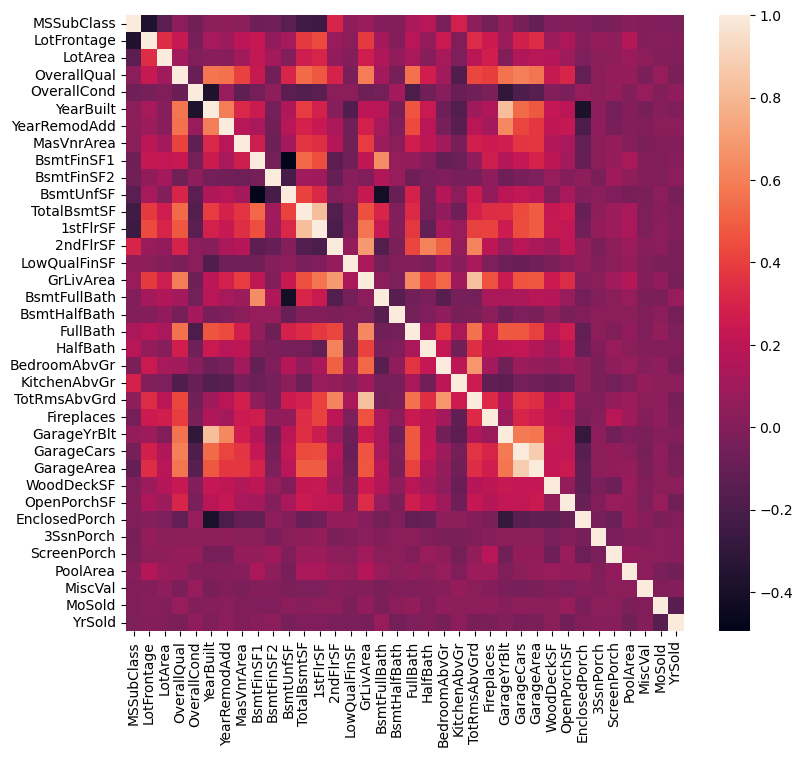

In [20]:
plt.subplots(figsize=(9,8))
sns.heatmap(housing_data.corr(numeric_only=True));

___
<a id="feature_selection"></a>
# 2&nbsp; Feature Selection

In this section we will construct and test two kinds of feature selectors: **Sequential Feature Selector** (SFS) and **Recursive Feature Eliminator** (RFE).

We will compare the the performance (runtime and test accuracy) of each selector to a reference pipeline that only contains preprocessing and a classifier.

Let's create two little helper functions, one that gives out the model metrics and one that will return the features that the selectors will choose.

In [21]:
def get_model_metrics(y_true, y_pred):
    metrics = pd.DataFrame({
        "R2": r2_score(y_true=y_true, y_pred=y_pred),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_pred),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred),
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_pred),
        "RMSE_log": mean_squared_log_error(y_true=y_true, y_pred=y_pred)
    }, index=[0]).round(3)
    return metrics

def get_selected_features(preprocessing_pipeline, feature_selector):
    selected_features = pd.DataFrame({
        "preprocessing_features": preprocessing_pipeline.get_feature_names_out(),
        "selected_features": feature_selector.get_support()
    })
    selected_features = selected_features.loc[selected_features["selected_features"] == True, "preprocessing_features"]
    return selected_features

Here comes the reference model.

In [22]:
reference_pipeline = make_pipeline(
    preprocessing_pipe, 
    RandomForestRegressor()
)

reference_pipeline.fit(X_train, y_train)

get_model_metrics(y_true=y_test, y_pred=reference_pipeline.predict(X_test))

,R2,MAE,MAPE,MSE,RMSE_log
0,0.891,17376.94,0.106,8.350648e+08,0.023


<a id="sfs"></a>
### 2.1&nbsp; Sequential Feature Selection

Sequential Feature Selection is a greedy approach that starts adds or removes features based on their contribution to a given evaluation criterion (e.g. accuracy score). It can either start with an empty feature list and iteratively add features, or it can start with the whole feature list and remove features one by one. It continues to do so until a certain threshold is met (e.g. the number of features to select).

In [31]:
feature_selector_sequential = SequentialFeatureSelector(
    estimator=DecisionTreeRegressor(), 
    n_features_to_select=10, # 10 features should be sufficient to properly predict housing prices
    direction="forward", # start with all features and iteratively remove the least effective ones
    scoring="neg_root_mean_squared_error" # scoring function - this is a regressor, thus we'll use 
)

selector_pipeline = make_pipeline(
    preprocessing_pipe,
    feature_selector_sequential
)

In [32]:
full_pipe_selected_features = make_pipeline(
    preprocessing_pipe, 
    feature_selector_sequential,
    RandomForestRegressor()
)

full_pipe_selected_features.fit(X_train, y_train)

get_model_metrics(y_true=y_test, y_pred=full_pipe_selected_features.predict(X_test))

,R2,MAE,MAPE,MSE,RMSE_log
0,0.773,26574.781,0.162,1.741817e+09,0.046


In [33]:
# Number of selected features
print("Number of selected features: ", feature_selector_sequential.get_support().sum())

# Selected features:
selected_features = get_selected_features(preprocessing_pipe, feature_selector_sequential)
print(selected_features)

Number of selected features:  10
3                            num_pipe__OverallQual
16                          num_pipe__BsmtFullBath
25                            num_pipe__GarageCars
36            cat_pipe__cat_nominal__BldgType_1Fam
52          cat_pipe__cat_nominal__Condition2_Norm
98       cat_pipe__cat_nominal__GarageType_BuiltIn
123    cat_pipe__cat_nominal__Neighborhood_Blmngtn
129    cat_pipe__cat_nominal__Neighborhood_Crawfor
147    cat_pipe__cat_nominal__Neighborhood_Veenker
169              cat_pipe__cat_ordinal__GarageCond
Name: preprocessing_features, dtype: object


We reduced the dimensions from ~180 columns that the preprocessing pipeline spits out to only 10 using the `SequentialFeatureSelector`. However, our predictions got a lot worse (R^2 = 0.77).

Also, the runtime is very long with the `"backward"` direction. I also tested the `"forward"` direction, but that resulted in even worse test results. In my opinion, it makes sense to start with all features and eliminate the worst ones, instead of starting with no features and adding the ones that do at least somewhat increase the scoring. So I'd go for `direction="backward"`, even though the runtime is very high. 

However, since the predictions got so much worse, I'm not gonna use the `SequentialFeatureSelector` at all. At other times, the selector makes a lot of sense, runs quickly and reduces the dimensionality without decreasing performance, but not for our task at hand.

<a id="RFE"></a>
### 2.2&nbsp; Recursive Feature Elimination with Cross Validation

Recursive Feature Elimination starts with the full set of features and iteratively removes features based on their importance, as determined by a chosen estimator (we will use a DecisionTreeClassifier).

In [34]:
feature_selector_recursive = RFECV(
    estimator=DecisionTreeRegressor(),
    cv=5 # number of cross validation splits
)

selector_pipeline = make_pipeline(
    preprocessing_pipe,
    feature_selector_recursive
)

In [35]:
full_pipe_selected_features = make_pipeline(
    preprocessing_pipe, 
    feature_selector_recursive,
    RandomForestRegressor()
)

full_pipe_selected_features.fit(X_train, y_train)

get_model_metrics(y_true=y_test, y_pred=full_pipe_selected_features.predict(X_test))

,R2,MAE,MAPE,MSE,RMSE_log
0,0.89,17593.382,0.105,8.462765e+08,0.023


In [46]:
# Number of selected features
print("Number of selected features: ", feature_selector_recursive.get_support().sum())

# Selected features:
selected_features = get_selected_features(preprocessing_pipe, feature_selector_recursive)
print(selected_features)

Number of selected features:  142
0                      num_pipe__MSSubClass
1                     num_pipe__LotFrontage
2                         num_pipe__LotArea
3                     num_pipe__OverallQual
4                     num_pipe__OverallCond
                       ...                 
179       cat_pipe__cat_ordinal__PavedDrive
180           cat_pipe__cat_ordinal__PoolQC
181         cat_pipe__cat_ordinal__RoofMatl
182    cat_pipe__cat_ordinal__SaleCondition
183         cat_pipe__cat_ordinal__SaleType
Name: preprocessing_features, Length: 142, dtype: object


This looks a lot better. With the RFE we have a relatively short runtime (13.6s), a reduction of the number of features from **~180 to 142**, and **no reduction in performance** (Baseline R^2 and RMSE: 0.89 and 0.023 -> RFE: 0.89 and 0.023).

We'll test the RFE as feature selector in our Model_Training_and_Selection script. If the runtimes won't be too high, we might go for this feature selector to try and optimize our models.